<a href="https://colab.research.google.com/github/SameeshaKulasekara/Deep_Learning/blob/main/Lab7/lab_7_AE_CNN_Image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


4422102/4422102 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [4]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1)
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[ 1.3477998 ],
         [-0.2623508 ],
         [ 0.23077841],
         ...,
         [-0.70143265],
         [-1.8539535 ],
         [-0.13733663]],

        [[ 0.70763993],
         [ 0.22796565],
         [ 1.4801736 ],
         ...,
         [-0.18152355],
         [-0.3764361 ],
         [ 0.10620496]],

        [[-0.0563577 ],
         [ 1.0175853 ],
         [ 0.5739183 ],
         ...,
         [-0.7611071 ],
         [ 0.11382069],
         [ 0.5083518 ]],

        ...,

        [[ 0.8888038 ],
         [-2.4210072 ],
         [-1.2865887 ],
         ...,
         [-1.9601293 ],
         [-0.4337935 ],
         [-1.5217406 ]],

        [[ 0.3692549 ],
         [ 1.4760008 ],
         [ 0.6262261 ],
         ...,
         [ 1.3229603 ],
         [ 0.09637903],
         [ 0.00384735]],

        [[-1.5719182 ],
         [-0.3349344 ],
         [ 1.069556  ],
         ...,
         [-0.7545849 ],
         [ 0.032

In [6]:
noise_factor = 0.2
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape)
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0)
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

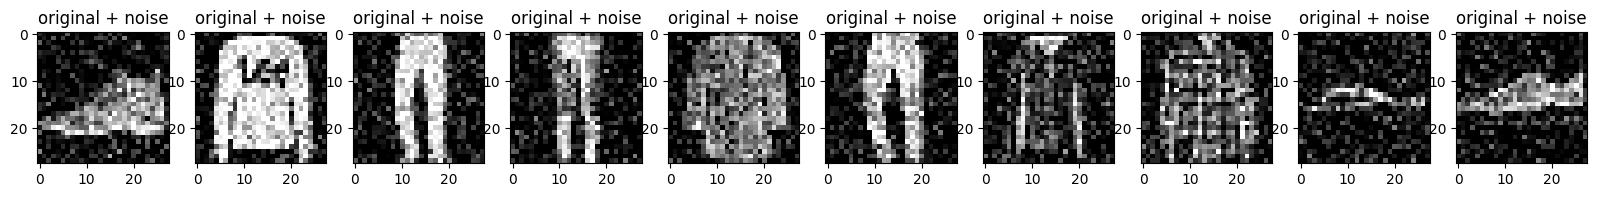

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [9]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [55]:
noise_factors = [0.1, 0.2, 0.3, 0.4, 0.5]


In [54]:
from skimage.util import random_noise  # Import random_noise function

for noise_factor in noise_factors:
    # Add noise to the test data
    x_test_noisy = np.array([random_noise(image, var=noise_factor) for image in x_test])

    # Clip noisy data to [0, 1] range
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

    # Define denoising autoencoder architecture
    class Denoise(Model):
        def __init__(self):
            super(Denoise, self).__init__()
            self.encoder = tf.keras.Sequential([
                layers.Input(shape=(28, 28, 1)),
                layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
                layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

            self.decoder = tf.keras.Sequential([
                layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
                layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
                layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

In [15]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/30
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 2/30
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 3/30
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 4/30
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 5/30
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 6/30
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 7/30
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 8/30
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 9/30
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 10/30
1875/1875 [==============================] - 81s 43m

In [30]:
# Calculate test loss
test_loss = autoencoder.evaluate(x_test_noisy, x_test_noisy)
print("Test Loss (MSE) for Denoising Autoencoder:", test_loss)

313/313 [==============================] - 7s 23ms/step - loss: 0.0845
Test Loss (MSE) for Denoising Autoencoder: 0.08452319353818893


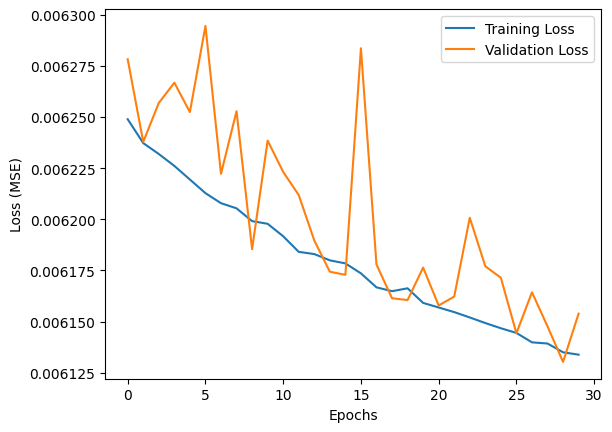

In [49]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [50]:
autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
autoencoder.decoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

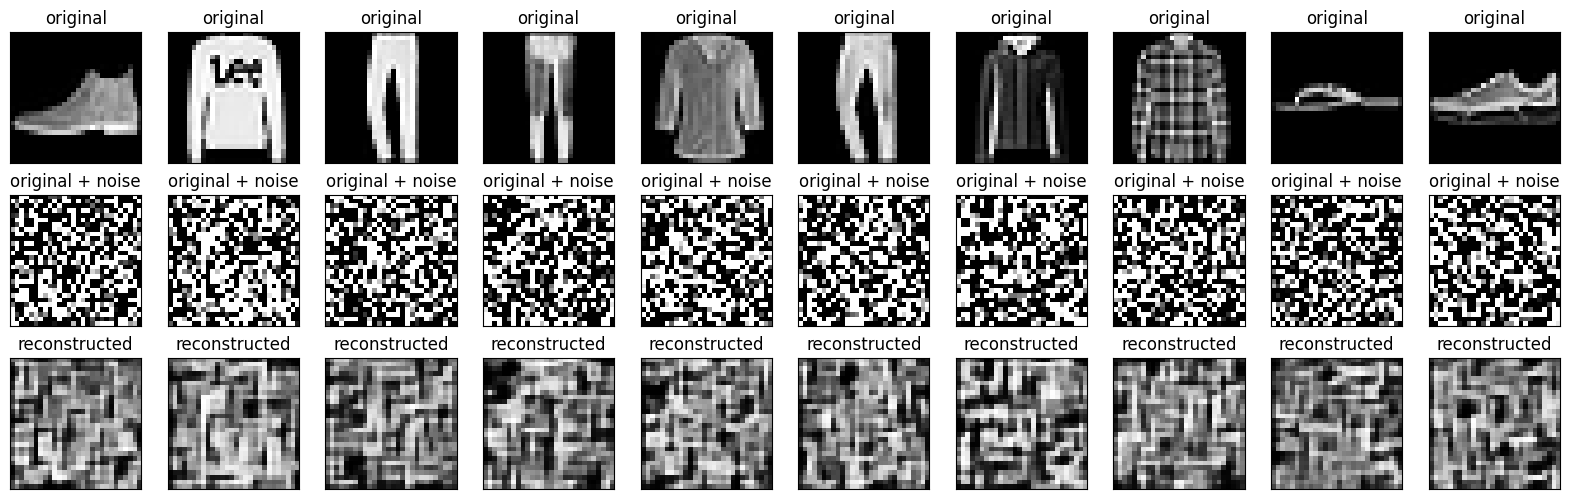

In [53]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()